# Transforming Education System

## Loading the libraries

In [1]:
%matplotlib inline
from __future__ import division
from __future__ import print_function

# ignore deprecation warnings in sklearn
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import os
import sys

# adding the 'src' directory as one where we can import modules
src_dir = os.path.join(os.getcwd(), os.pardir, 'src')
sys.path.append(src_dir)

from data.multilabel import multilabel_sample_dataframe, multilabel_train_test_split
from features.SparseInteractions import SparseInteractions
from models.metrics import multi_multi_log_loss

## Loading the Data

In [2]:
path_to_training_data = os.path.join(os.pardir,
                                     'data',
                                     'TrainingData.csv')

df = pd.read_csv(path_to_training_data, index_col=0)

print(df.shape)

(400277, 25)


In [3]:
# printing dataset information
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400277 entries, 134338 to 415831
Data columns (total 25 columns):
Function                  400277 non-null object
Use                       400277 non-null object
Sharing                   400277 non-null object
Reporting                 400277 non-null object
Student_Type              400277 non-null object
Position_Type             400277 non-null object
Object_Type               400277 non-null object
Pre_K                     400277 non-null object
Operating_Status          400277 non-null object
Object_Description        375493 non-null object
Text_2                    88217 non-null object
SubFund_Description       306855 non-null object
Job_Title_Description     292743 non-null object
Text_3                    179964 non-null object
Text_4                    53746 non-null object
Sub_Object_Description    91603 non-null object
Location_Description      162054 non-null object
FTE                       126071 non-null float64
Func

## Exploratory Data Analysis

                 FTE         Total
count  126071.000000  3.957220e+05
mean        0.426794  1.310586e+04
std         0.573576  3.682254e+05
min        -0.087551 -8.746631e+07
25%         0.000792  7.379770e+01
50%         0.130927  4.612300e+02
75%         1.000000  3.652662e+03
max        46.800000  1.297000e+08


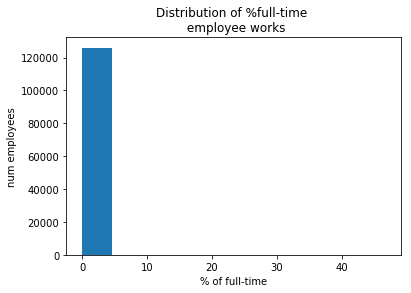

In [4]:
# Printing the summary statistics
print(df.describe())

# Importing matplotlib.pyplot as plt
import matplotlib.pyplot as plt

# Creating the histogram
plt.hist(df['FTE'].dropna())

# Adding title and labels
plt.title('Distribution of %full-time \n employee works')
plt.xlabel('% of full-time')
plt.ylabel('num employees')

# Displaying the histogram
plt.show()

In [5]:
# printing out how the dataset looks like
df.head(n=3)

,Function,Use,Sharing,Reporting,Student_Type,Position_Type,Object_Type,Pre_K,Operating_Status,Object_Description,...,Sub_Object_Description,Location_Description,FTE,Function_Description,Facility_or_Department,Position_Extra,Total,Program_Description,Fund_Description,Text_1
134338,Teacher Compensation,Instruction,School Reported,School,NO_LABEL,Teacher,NO_LABEL,NO_LABEL,PreK-12 Operating,NaN,...,NaN,NaN,1.0,NaN,NaN,KINDERGARTEN,50471.81,KINDERGARTEN,General Fund,NaN
206341,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,Non-Operating,CONTRACTOR SERVICES,...,NaN,NaN,NaN,RGN GOB,NaN,UNDESIGNATED,3477.86,BUILDING IMPROVEMENT SERVICES,NaN,BUILDING IMPROVEMENT SERVICES
326408,Teacher Compensation,Instruction,School Reported,School,Unspecified,Teacher,Base Salary/Compensation,Non PreK,PreK-12 Operating,Personal Services - Teachers,...,NaN,NaN,1.0,NaN,NaN,TEACHER,62237.13,Instruction - Regular,General Purpose School,NaN


# Resampling the Data

400,277 rows is too many observations to work on my local machine. So I have sampled it down to 40,000 rows so that it is easy and quick to run the analysis. We'll also create dummy variables for the target labels and split the sampled dataset into a training set and a test set.

In [6]:
LABELS = ['Function',
          'Object_Type',
          'Operating_Status',
          'Position_Type',
          'Pre_K',
          'Reporting',
          'Sharing',
          'Student_Type',
          'Use']

NON_LABELS = [c for c in df.columns if c not in LABELS]

SAMPLE_SIZE = 40000

sampling = multilabel_sample_dataframe(df,
                                       pd.get_dummies(df[LABELS]),
                                       size=SAMPLE_SIZE,
                                       min_count=25,
                                       seed=43)

dummy_labels = pd.get_dummies(sampling[LABELS])

X_train, X_test, y_train, y_test = multilabel_train_test_split(sampling[NON_LABELS],
                                                               dummy_labels,
                                                               0.2,
                                                               min_count=3,
                                                               seed=43)

## Counting Unique Labels

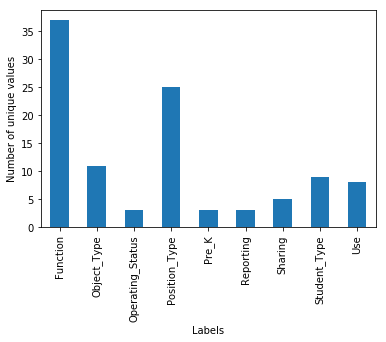

In [7]:
# Calculating number of unique values for each label
num_unique_labels = df[LABELS].apply(pd.Series.nunique)

# Plotting number of unique values for each label
num_unique_labels.plot(kind='bar')

# Labelling the axes
plt.xlabel('Labels')
plt.ylabel('Number of unique values')

# Displaying the plot
plt.show()

## Preprocessing the Data

In [8]:
NUMERIC_COLUMNS = ['FTE', "Total"]

def combine_text_columns(data_frame, to_drop=NUMERIC_COLUMNS + LABELS):
    """ Takes the dataset as read in, drops the non-feature, non-text columns and
        then combines all of the text columns into a single vector that has all of
        the text for a row.
        
        :param data_frame: The data as read in with read_csv 
        :param to_drop: Removes the numeric and target label columns.
    """
    # dropping non-text columns that are in the df
    to_drop = set(to_drop) & set(data_frame.columns.tolist())
    text_data = data_frame.drop(to_drop, axis=1)
    
    # replacing nans with blanks
    text_data.fillna("", inplace=True)
    
    # joining all of the text items in a row (axis=1) with a space in between
    return text_data.apply(lambda x: " ".join(x), axis=1)


In [9]:
from sklearn.preprocessing import FunctionTransformer

get_text_data = FunctionTransformer(combine_text_columns, validate=False)
get_numeric_data = FunctionTransformer(lambda x: x[NUMERIC_COLUMNS], validate=False)

In [10]:
from sklearn.metrics.scorer import make_scorer

log_loss_scorer = make_scorer(multi_multi_log_loss)

# Training the model

Now we'll train our model that takes text and numeric data, does the necessary preprocessing, and trains the classifier.

In [11]:
from sklearn.feature_selection import chi2, SelectKBest

from sklearn.pipeline import Pipeline, FeatureUnion

from sklearn.preprocessing import Imputer
from sklearn.feature_extraction.text import HashingVectorizer

from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import MaxAbsScaler

TOKENS_ALPHANUMERIC = '[A-Za-z0-9]+(?=\\s+)'

In [14]:
%%time

# setting a reasonable number of features before adding interactions
chi_k = 300

# creating the pipeline object
pl = Pipeline([
        ('union', FeatureUnion(
            transformer_list = [
                ('numeric_features', Pipeline([
                    ('selector', get_numeric_data),
                    ('imputer', Imputer())
                ])),
                ('text_features', Pipeline([
                    ('selector', get_text_data),
                    ('vectorizer', HashingVectorizer(token_pattern=TOKENS_ALPHANUMERIC,
                                                     non_negative=True, norm=None, binary=False,
                                                     ngram_range=(1, 2))),
                    ('dim_red', SelectKBest(chi2, chi_k))
                ]))
             ]
        )),
        ('int', SparseInteractions(degree=2)),
        ('scale', MaxAbsScaler()),
        ('clf', OneVsRestClassifier(LogisticRegression()))
    ])

# fitting the pipeline to our training data
pl.fit(X_train, y_train.values)

# printing the score of our trained pipeline on our test set
print("Logloss score of trained pipeline: ", log_loss_scorer(pl, X_test, y_test.values))

# Computing and printing accuracy
accuracy = pl.score(X_test, y_test)
print("\nAccuracy on test dataset: ", accuracy)

Logloss score of trained pipeline:  1.57055491551

Accuracy on test dataset:  0.709125
Wall time: 9min 55s


Random Forest Classifier is also used for different values of n_estimator parameter. The optimized parameter (n_estimators=2) in the above model is found out after changing its value from 1 to 15. Although using Random Forest Classifier log loss value has improved but its accuracy got decreased as well. A plot of the logloss value Vs number of n_estimators has been included in the report.

## Predicting Class Probabilities for the holdout set 

In [15]:
path_to_holdout_data = os.path.join(os.pardir,
                                    'data',
                                    'TestData.csv')

# Loading holdout data
holdout = pd.read_csv(path_to_holdout_data, index_col=0)

# Making predictions
predictions = pl.predict_proba(holdout)

#temp = pd.DataFrame(np.array(predictions).reshape(100128,104))
# Formatting correctly in new DataFrame: prediction_df
prediction_df = pd.DataFrame(columns=pd.get_dummies(df[LABELS]).columns,
                             index=holdout.index,
                             data=predictions)


# Saving prediction_df to csv called "predictions.csv"
prediction_df.to_csv("predictions.csv")

In [16]:
prediction_df.head(n=3)

,Function_Aides Compensation,Function_Career & Academic Counseling,Function_Communications,Function_Curriculum Development,Function_Data Processing & Information Services,Function_Development & Fundraising,Function_Enrichment,Function_Extended Time & Tutoring,Function_Facilities & Maintenance,Function_Facilities Planning,...,Student_Type_Special Education,Student_Type_Unspecified,Use_Business Services,Use_ISPD,Use_Instruction,Use_Leadership,Use_NO_LABEL,Use_O&M,Use_Pupil Services & Enrichment,Use_Untracked Budget Set-Aside
180042,0.005274,0.001482,0.000229,0.001937,0.008484,0.000314,0.015434,0.003651,0.002365,0.000299,...,0.001664,0.990780,0.008069,0.010891,0.906155,0.002265,0.013720,0.008015,0.018206,0.007107
28872,0.004771,0.002679,0.000424,0.001820,0.005278,0.000341,0.979124,0.004343,0.003534,0.000354,...,0.033664,0.861673,0.006438,0.016902,0.008880,0.012714,0.047771,0.012545,0.476751,0.002144
186915,0.176965,0.003575,0.000121,0.002618,0.002810,0.000131,0.000968,0.000054,0.001705,0.000204,...,0.011956,0.663888,0.002052,0.015685,0.958147,0.001064,0.081520,0.000519,0.001759,0.000474
